In [1]:
import torch
import sys
sys.path.append('../vega/')
import vega
import scanpy as sc
import scvi
from scipy import sparse
from sklearn import preprocessing
import numpy as np
from intercode import Intercode

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
path_to_save = '../paper/figures/regression_latent/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
font = {'family' : 'Arial',
        'size'   : 14}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
# Scanpy figures params
sc.set_figure_params(dpi_save=300)
sc.settings.figdir = path_to_save

In [2]:
# Reload model and data
model_vega = vega.VEGA.load('../trained_models/vega_model/')
model_intercode = Intercode.load('../trained_models/intercode_model/', adata=model_vega.adata)

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Inserting terms' names and activities to the Anndata object.


In [3]:
import pandas as pd
df_intercode = pd.DataFrame(data=model_intercode.encode(model_vega.adata.X.A),
                           columns = model_vega.adata.uns['_vega']['gmv_names'],
                           index=np.arange(len(model_vega.adata)))
df_vega = pd.DataFrame(data=model_vega.to_latent(model_vega.adata, return_mean=True),
                    columns=model_vega.adata.uns['_vega']['gmv_names'],
                    index=np.arange(len(model_vega.adata)))


In [6]:
list_pathways = ['REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM',
                'REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES',
                 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
                 'REACTOME_INTERFERON_SIGNALING'
                ]
model_dict = {'VEGA':df_vega, 'Intercode':df_intercode}
res_dict = {'VEGA':{'Accuracy':[], 'Pathway':[]}, 'Intercode':{'Accuracy':[], 'Pathway':[]}}
from sklearn.linear_model import LogisticRegression
y = model_vega.adata.obs['condition'].values
for m in model_dict:
    for p in list_pathways:
        X = model_dict[m][p].values.reshape(-1, 1)
        cls = LogisticRegression(random_state=42)
        cls.fit(X,y)
        score = cls.score(X,y)
        res_dict[m]['Accuracy'].append(score)
        res_dict[m]['Pathway'].append('_'.join(p.split('_')[1:]))


In [7]:
res_vega = pd.DataFrame(res_dict['VEGA'])
res_vega['Model'] = 'VEGA'
res_intercode = pd.DataFrame(res_dict['Intercode'])
res_intercode['Model'] = 'Intercode'
res = pd.concat([res_vega, res_intercode])

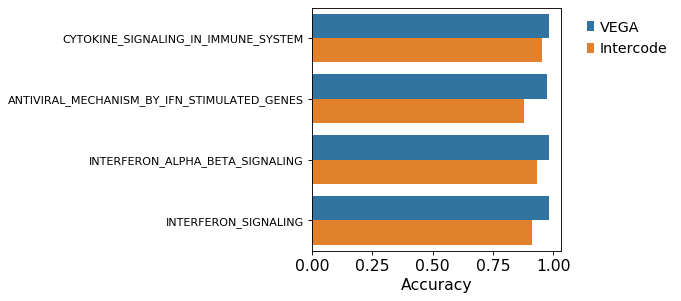

In [10]:
bplt = sns.barplot(data=res, y='Pathway', x='Accuracy', hue='Model')
plt.grid(False)
plt.ylabel('')
plt.yticks(fontsize=10)
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.savefig(path_to_save+'intercode_vega_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [32]:
print('Mean Accuracy VEGA:', np.mean(res['Accuracy'][:4]))
print('Mean Accuracy Intercode:', np.mean(res['Accuracy'][5:]))

Mean Accuracy VEGA: 0.9814633241467033
Mean Accuracy Intercode: 0.9085576991025368


In [20]:
# Run time per epochs
with open('../trained_models/vega_time.txt', 'r') as f:
    l = f.readlines()
    for line in l:
        t_vega = float(line.split(':')[-1])
        
with open('../trained_models/intercode_time.txt', 'r') as f:
    l = f.readlines()
    for line in l:
        t_inter = float(line.split(':')[-1])

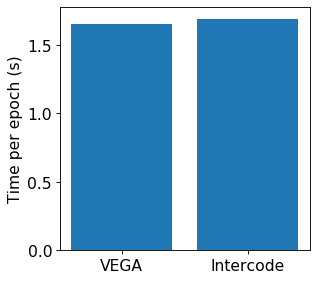

In [26]:
plt.grid(False)
tpe = np.array([t_vega, t_inter])/len(model_vega.epoch_history['train_loss'])
plt.bar(x=['VEGA', 'Intercode'], height=tpe)
plt.ylabel('Time per epoch (s)')
#plt.savefig(path_to_save+'intercode_vega_time.pdf', format='pdf', dpi=300, bbox_inches='tight')